BDSIM output file - using DataLoader


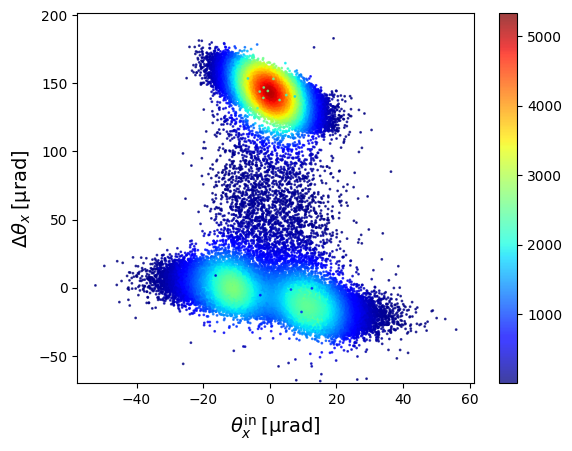

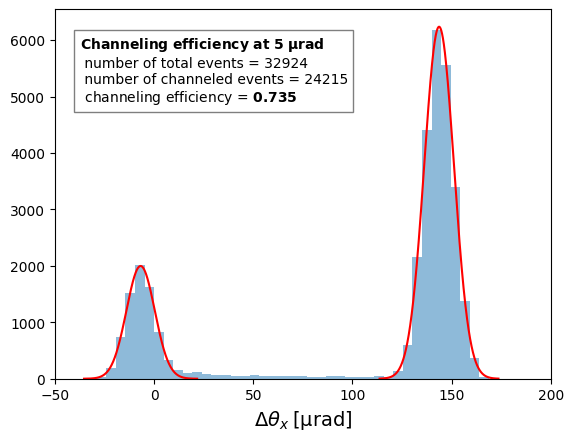

mu channeling peak: 143.6671696821126
sigma channeling peak: 7.4967045312697005


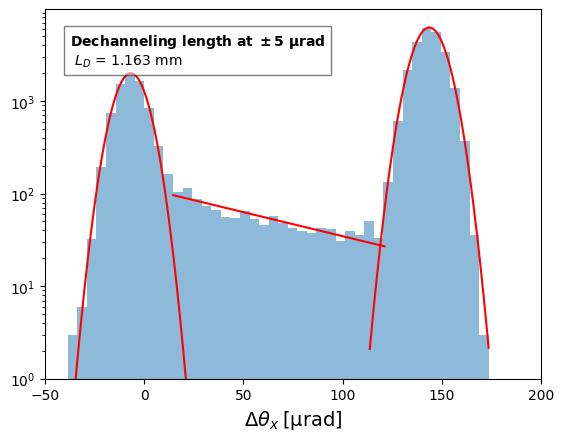

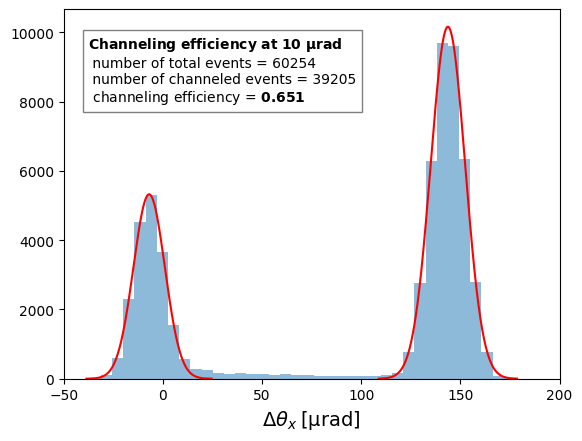

mu channeling peak: 143.70551512583836
sigma channeling peak: 8.719427992292145


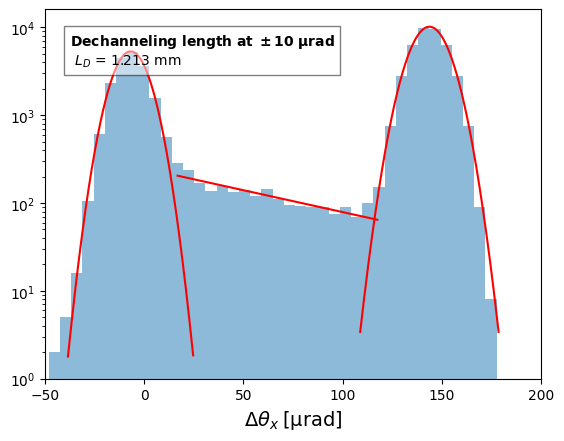

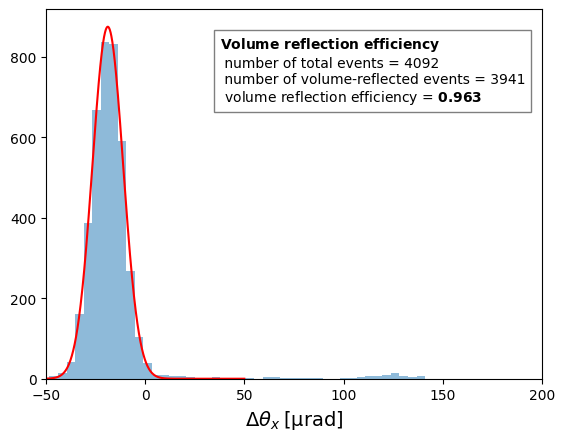

mu vr peak: -18.903702049097145
sigma vr peak: 7.75428530221862


In [4]:
import ROOT
import pybdsim

import numpy as np
from scipy.stats import gaussian_kde, norm
from multiprocessing import Pool, cpu_count
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt


def load_data(bdsim_outfile):
    
    data = pybdsim.Data.Load(bdsim_outfile)
    
    return data


def get_phaseSpace_data(data, incident_or_outgoing):
    
    if incident_or_outgoing == 'incident':
        phaseSpace_data = pybdsim.Data.PhaseSpaceData(data, 0)
        
    elif incident_or_outgoing == 'outgoing':  
        phaseSpace_data = pybdsim.Data.PhaseSpaceData(data, 1)
        
    else:
        raise ValueError("incident_or_outgoing must be either incident or outgoing.")
    
    return phaseSpace_data
    

def get_crystalExit_samplerData(data):
    
    return pybdsim.Data.SamplerData(data, 1)


def gaussian(x_axis, A, mu, sigma):
    
    return A * np.exp(-(x_axis - mu)**2 / (2 * sigma**2))


def dechanneling_exp(x_axis, A, par1):
    
    return A * np.exp(-x_axis / par1)


def get_lCryst(crystal_samplerData):
    
    offset = 1e3 # um
    l_cryst = round(crystal_samplerData.data['S'][0]*1e6 - offset) # um
    
    return l_cryst
    

def get_energy(phaseSpace_data):
    
    energy = np.mean(phaseSpace_data.data['energy'])*1e9
    
    return energy


def get_critical_angle(energy, crystal):
    
    # Note: for the purposes of this code it is sufficient to have an approximate number for the critical angle.
    # Therefore, no distictions between different potential wells are made.
    if crystal == 'Si':
        U0 = 20 # eV
    else:
        raise ValueError("Crystals other than Si are not supported yet.")
    
    critical_angle = round(np.sqrt(2*U0/energy)*1e6 / 5)*5 # urad
    
    return critical_angle    


def get_distribution(plane, phaseSpace_data):
    
    if plane == 'h':
        u = phaseSpace_data.data['x']
        up = phaseSpace_data.data['xp']
    elif plane == 'v':
        u = phaseSpace_data.data['y']
        up = phaseSpace_data.data['yp'] 
    else:
        raise ValueError("Plane must be either horizontal (h) or vertical (v).")
        
    return u, up


def plot_distribution(x, xp, y, yp, fit_gaussian, show_plot, save_plot, dpi):
    
    x_edge = max(max(x), abs(min(x)))
    xp_edge = max(max(xp), abs(min(xp)))
    
    y_edge = max(max(y), abs(min(y)))
    yp_edge = max(max(yp), abs(min(yp)))
    
    if fit_gaussian:
        
        x_axis = np.arange(-x_edge, x_edge, 2*x_edge/1e3)
        xp_axis = np.arange(-xp_edge, xp_edge, 2*xp_edge/1e3)
        
        y_axis = np.arange(-y_edge, y_edge, 2*y_edge/1e3)
        yp_axis = np.arange(-yp_edge, yp_edge, 2*yp_edge/1e3)
        
        mu_x, sigma_x  = (np.mean(x), np.std(x))
        mu_xp, sigma_xp = (np.mean(xp), np.std(xp))
        
        mu_y, sigma_y  = (np.mean(y), np.std(y))
        mu_yp, sigma_yp = (np.mean(yp), np.std(yp))
     
    # Make the plot
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(x * 1e+3, density=True, bins=50, alpha=0.5)
    plt.title('Horizontal impacting distribution', fontsize=14)
    plt.xlabel('x [mm]', fontsize=14)
    plt.xlim([-x_edge*1e+3, x_edge*1e+3])
    if fit_gaussian:
        plt.plot(x_axis*1e+3, norm.pdf(x_axis*1e3, mu_x*1e3, sigma_x*1e3), color='red', linewidth=1.5)

    plt.subplot(2, 2, 2)
    plt.hist(y * 1e+3, density=True, bins=50, alpha=0.5)
    plt.title('Vertical impacting distribution', fontsize=14)
    plt.xlabel('y [mm]', fontsize=14)
    plt.xlim([-y_edge*1e+3, y_edge*1e+3])
    if fit_gaussian:
        plt.plot(y_axis*1e+3, norm.pdf(y_axis*1e+3, mu_y*1e3, sigma_y*1e3), color='red', linewidth=1.5)

    plt.subplot(2, 2, 3)
    plt.hist(xp * 1e+6, density=True, bins=50, alpha=0.5)
    plt.xlabel(r'$\theta_{x}^{\mathrm{in}}\:[\mathrm{\mu rad}]$', fontsize=14)
    plt.xlim([-xp_edge*1e+6, xp_edge*1e+6])
    if fit_gaussian:
        plt.plot(xp_axis*1e+6, norm.pdf(xp_axis*1e+6, mu_xp*1e6, sigma_xp*1e6), color='red', linewidth=1.5)

    plt.subplot(2, 2, 4)
    plt.hist(yp * 1e+6, density=True, bins=50, alpha=0.5)
    plt.xlabel(r'$\theta_{y}^{\mathrm{in}}\:[\mathrm{\mu rad}]$', fontsize=14)
    plt.xlim([-yp_edge*1e+6, yp_edge*1e+6])
    if fit_gaussian:
        plt.plot(yp_axis*1e+6, norm.pdf(yp_axis*1e+6, mu_yp*1e6, sigma_yp*1e6), color='red', linewidth=1.5)

    plt.tight_layout()  # Adjust spacing between subplots
    
    if save_plot:
        plt.savefig('impacting_distribution.png', dpi=dpi, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    
    return


def get_surviving_primaries(crystal_samplerData, x, xp, y, yp):
    
    mask_surviving_primaries = crystal_samplerData.data['n'] == 1
    
    x = x[mask_surviving_primaries]
    xp = xp[mask_surviving_primaries]
    y = y[mask_surviving_primaries]
    yp = yp[mask_surviving_primaries]
    
    return x, xp, y, yp
    

def do_gaussian_kde(data):
    thetax_incident, delta_thetax = data
    kde = gaussian_kde(np.vstack([thetax_incident, delta_thetax]))
    density = kde(np.vstack([thetax_incident, delta_thetax]))
    return density


def split_data_for_multiprocessing(xp, delta_xp):
    
    num_processes = cpu_count()
    chunk_size = len(xp) // num_processes
    data_chunks = [(xp[i:i + chunk_size], delta_xp[i:i + chunk_size]) for i in range(0, len(xp), chunk_size)]
    
    # Avoid data chunk with just one value (can cause issues sometimes)
    if len(data_chunks[-1][0]) < 2:
        num_processes = cpu_count() - 1
        chunk_size = len(xp) // num_processes
        data_chunks = [(xp[i:i + chunk_size], delta_xp[i:i + chunk_size]) for i in range(0, len(xp), chunk_size)]
        
    return data_chunks, num_processes


def get_density_with_multiprocessing(data_chunks, num_processes):
    
    with Pool(processes=num_processes) as pool:
        density_list = pool.map(do_gaussian_kde, data_chunks)
        
    density = np.concatenate(density_list)
    
    return density


def introduce_exp_resolution(data, mu_noise, sigma_noise):
    # introduce experimental resolution as a random gaussian noise
    noise = np.random.normal(mu_noise, sigma_noise, len(data))
    data = data + noise
    
    return data
    

def plot_angular_deflection(xp, delta_xp, bending_angle, density, show_plot, save_plot, dpi):
    
    scatter = plt.scatter(xp*1e6, delta_xp*1e6, c=density, cmap='jet', alpha=0.75, s=1)
    plt.xlabel(r'$\theta_{x}^{\mathrm{in}}\:[\mathrm{\mu rad}]$', fontsize=14)
    plt.ylabel(r'$\Delta\theta_{x}\:[\mathrm{\mu rad}]$', fontsize=14)
    plt.colorbar()
    plt.ylim([-70, bending_angle*1.4])
    
    if save_plot:
        plt.savefig('planar_channeling.png', dpi=dpi, bbox_inches='tight')
    
    if show_plot:
        plt.show()
        
    return


def apply_angular_cut(xp_in, xp_out, cut):
    
    mask_angular_cut = (xp_in >= cut[0]) & (xp_in <= cut[1])
    
    xp_in_cut = xp_in[mask_angular_cut]
    xp_out_cut = xp_out[mask_angular_cut]
    
    delta_xp_cut = xp_out_cut - xp_in_cut
    
    return delta_xp_cut


def find_and_fit_peaks(delta_xp, bending_angle, critical_angle, bins, which_peak):
    
    hist = plt.hist(delta_xp*1e6, bins=bins)
    plt.close()
    
    hist_values = np.array(hist[0])
    hist_bins = np.array(hist[1])

    binwidth = hist_bins[1] - hist_bins[0]

    if which_peak == 'nc':
    
        # Select the non-channeling macro region
        mask_nonChanneling_peak = (hist[1] > -50) & (hist[1] < 20)    
        hist_values_nc = hist_values[np.argwhere(mask_nonChanneling_peak)[0][0]:np.argwhere(mask_nonChanneling_peak)[-1][0]]
        hist_bins_nc = hist_bins[np.argwhere(mask_nonChanneling_peak)[0][0]:np.argwhere(mask_nonChanneling_peak)[-1][0]]
        
        maximum_nc = max(hist_values_nc)
        position_nc = hist_bins_nc[np.argmax(hist_values_nc)]
        
        # gaussian fit non-channeling peak
        nonChanneling_peak, covariance = curve_fit(gaussian, hist_bins_nc + binwidth/2, hist_values_nc,
                                            p0=[maximum_nc, position_nc + binwidth/2, np.std(hist_bins_nc + binwidth/2)])
        
        return nonChanneling_peak
        
    elif which_peak == 'c':
    
        # Select the channeling macro region
        mask_channeling_peak = (hist[1] > bending_angle-20) & (hist[1] < bending_angle+20)    
        hist_values_ch = hist_values[np.argwhere(mask_channeling_peak)[0][0]:np.argwhere(mask_channeling_peak)[-1][0]]
        hist_bins_ch = hist_bins[np.argwhere(mask_channeling_peak)[0][0]:np.argwhere(mask_channeling_peak)[-1][0]]
        
        maximum_ch = max(hist_values_ch)
        position_ch = hist_bins_ch[np.argmax(hist_values_ch)]
        
        # gaussian fit channeling peak
        channeling_peak, covariance = curve_fit(gaussian, hist_bins_ch + binwidth/2, hist_values_ch,
                                            p0=[maximum_ch, position_ch + binwidth/2, np.std(hist_bins_ch + binwidth/2)])
    
        return channeling_peak
    
    elif which_peak == 'vr':

        # Select the volume reflection macro region
        mask_vr_peak = (hist[1] > -50) & (hist[1] < 50)    
        hist_values_vr = hist_values[np.argwhere(mask_vr_peak)[0][0]:np.argwhere(mask_vr_peak)[-1][0]]
        hist_bins_vr = hist_bins[np.argwhere(mask_vr_peak)[0][0]:np.argwhere(mask_vr_peak)[-1][0]]
        
        maximum_vr = max(hist_values_vr)
        position_vr = hist_bins_vr[np.argmax(hist_values_vr)]
        
        # gaussian fit volume reflection peak
        vr_peak, covariance = curve_fit(gaussian, hist_bins_vr + binwidth/2, hist_values_vr,
                                            p0=[maximum_vr, position_vr + binwidth/2, np.std(hist_bins_vr + binwidth/2)])

        return vr_peak
    
    elif which_peak == 'am':

        # Select the amorphous macro region
        mask_am_peak = (hist[1] > -50) & (hist[1] < 50)    
        hist_values_am = hist_values[np.argwhere(mask_am_peak)[0][0]:np.argwhere(mask_am_peak)[-1][0]]
        hist_bins_am = hist_bins[np.argwhere(mask_am_peak)[0][0]:np.argwhere(mask_am_peak)[-1][0]]
        
        maximum_am = max(hist_values_am)
        position_am = hist_bins_am[np.argmax(hist_values_am)]
        
        # gaussian fit amorphous peak
        am_peak, covariance = curve_fit(gaussian, hist_bins_am + binwidth/2, hist_values_am,
                                            p0=[maximum_am, position_am + binwidth/2, np.std(hist_bins_am + binwidth/2)])

        return am_peak
    
    else:

        raise ValueError("which_peak must be either non-channeling (nc), channeling (c), volume reflection (vr) or amorphous (am).")


def compute_channeling_efficiency(delta_xp, mu_ch_peak, sigma_ch_peak):
    
    total_number_events = len(delta_xp)
    
    mask_channeled_part = (delta_xp*1e6 > mu_ch_peak-3*sigma_ch_peak) & (delta_xp*1e6 < mu_ch_peak+3*sigma_ch_peak)
    
    channeled_part = delta_xp[mask_channeled_part]
    
    n_channeled_part = len(channeled_part)
    
    channeling_efficiency = n_channeled_part / total_number_events
    
    return channeling_efficiency  


def plot_channeling_efficiency(delta_xp, bending_angle, critical_angle, bins, cut,
                               nonChanneling_peak, channeling_peak, channeling_efficiency,
                               show_plot, save_plot, dpi):
    
    n_total_events = len(delta_xp)
    
    # non-channeling peak parameters
    A_nc_peak, mu_nc_peak, sigma_nc_peak = nonChanneling_peak[0], nonChanneling_peak[1], nonChanneling_peak[2]

    # Channeling peak parameters
    A_ch_peak, mu_ch_peak, sigma_ch_peak = channeling_peak[0], channeling_peak[1], channeling_peak[2]
    
    x_axis_nc_peak = np.arange(mu_nc_peak-4*sigma_nc_peak, mu_nc_peak+4*sigma_nc_peak, 8*sigma_nc_peak/1e3)
    x_axis_ch_peak = np.arange(mu_ch_peak-4*sigma_ch_peak, mu_ch_peak+4*sigma_ch_peak, 8*sigma_ch_peak/1e3)
    
    plt.hist(delta_xp*1e6, bins=bins, alpha=0.5)
    plt.plot(x_axis_nc_peak, gaussian(x_axis_nc_peak, A_nc_peak, mu_nc_peak, sigma_nc_peak),
             linewidth=1.5, color='red')
    plt.plot(x_axis_ch_peak, gaussian(x_axis_ch_peak, A_ch_peak, mu_ch_peak, sigma_ch_peak),
             linewidth=1.5, color='red')
    plt.xlim([-50,200])
    
#     plt.axvline(mu_ch_peak-2*sigma_ch_peak)
#     plt.axvline(mu_ch_peak+2*sigma_ch_peak)
    
#     plt.axvline(mu_nc_peak-2*sigma_nc_peak)
#     plt.axvline(mu_nc_peak+2*sigma_nc_peak)
    
    plt.xlabel(r'$\Delta\theta_{x}\:[\mathrm{\mu rad}]$', fontsize=14)
    
    textbox = r"$\mathbf{Channeling\ efficiency\ at\ " + str(int(cut[1]*1e6)) + "\ \mathrm{\mathbf{\mu rad}}}$" \
    + "\n number of total events = " + str(n_total_events) \
    + "\n number of channeled events = " + str(int(n_total_events * channeling_efficiency)) \
    + "\n channeling efficiency = $\mathbf{" + str(round(channeling_efficiency, 3)) + "}$"
    
    if A_ch_peak > A_nc_peak:
        x_textbox = 0.05
    else:
        x_textbox = 0.4

    plt.text(x_textbox, 0.75, textbox, transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    
    if save_plot:
        cut = int(cut[1] * 1e6)
        plt.savefig(f'channeling_efficiency_{cut}urad_cut.png', dpi=dpi, bbox_inches='tight')
    
    if show_plot:
        plt.show()
        print('mu channeling peak: ' + str(mu_ch_peak))
        print('sigma channeling peak: ' + str(sigma_ch_peak))
        
    return


def compute_vr_efficiency(delta_xp, mu_vr_peak, sigma_vr_peak):

    total_number_events = len(delta_xp)
    
    mask_vr_part = (delta_xp*1e6 > mu_vr_peak-3*sigma_vr_peak) & (delta_xp*1e6 < mu_vr_peak+3*sigma_vr_peak)
    
    vr_part = delta_xp[mask_vr_part]
    
    n_vr_part = len(vr_part)
    
    vr_efficiency = n_vr_part / total_number_events
    
    return vr_efficiency 


def plot_volume_reflection(delta_xp, bending_angle, critical_angle, 
                           bins, cut, vr_peak, vr_efficiency,
                           show_plot, save_plot, dpi=600):
    
    n_total_events = len(delta_xp)
    
    # Volume reflection peak parameters
    A_vr_peak, mu_vr_peak, sigma_vr_peak = vr_peak[0], vr_peak[1], vr_peak[2]
    
    x_axis_vr_peak = np.arange(-5*critical_angle, 5*critical_angle, 10*critical_angle/1e3)
    
    plt.hist(delta_xp*1e6, bins=bins, alpha=0.5)
    plt.plot(x_axis_vr_peak, gaussian(x_axis_vr_peak, A_vr_peak, mu_vr_peak, sigma_vr_peak),
             linewidth=1.5, color='red')

    plt.xlim([-50,200])
    
    plt.xlabel(r'$\Delta\theta_{x}\:[\mathrm{\mu rad}]$', fontsize=14)
    
    textbox = r"$\mathbf{Volume\ reflection\ efficiency}$" \
            + "\n number of total events = " + str(n_total_events) \
            + "\n number of volume-reflected events = " + str(int(n_total_events * vr_efficiency)) \
            + "\n volume reflection efficiency = " + r"$\mathbf{" + str(round(vr_efficiency, 3)) + "}$"

    plt.text(0.35, 0.75, textbox, transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    
    if save_plot:
        plt.savefig(f'vr_efficiency.png', dpi=dpi, bbox_inches='tight')
    
    if show_plot:
        plt.show()
        print("mu vr peak: " + str(mu_vr_peak))
        print("sigma vr peak: " + str(sigma_vr_peak))
        
    return   


def fit_dechanneling(delta_xp, bending_angle, bins, nonChanneling_peak, channeling_peak):
    
    hist = plt.hist(delta_xp*1e6, bins=bins)
    plt.close()
    
    hist_values = np.array(hist[0])
    hist_bins = np.array(hist[1])

    binwidth = hist_bins[1] - hist_bins[0]
    
    mu_nc_peak = nonChanneling_peak[1]
    sigma_nc_peak = nonChanneling_peak[2]
    
    mu_ch_peak = channeling_peak[1]
    sigma_ch_peak = channeling_peak[2]
    
    # if bending_angle >= 125:
    #     n_sigma = 3
    # else:
    #     n_sigma = 2

    n_sigma = 3
    
    mask_dechanneling = (hist[1] > mu_nc_peak+n_sigma*sigma_nc_peak) & (hist[1] < mu_ch_peak-n_sigma*sigma_ch_peak)    
    hist_values_dc = hist_values[np.argwhere(mask_dechanneling)[0][0]:np.argwhere(mask_dechanneling)[-1][0]]
    hist_bins_dc = hist_bins[np.argwhere(mask_dechanneling)[0][0]:np.argwhere(mask_dechanneling)[-1][0]]
    
    # Exponential fit dechanneled particles
    par1_guess = (hist_bins_dc[-5] - hist_bins_dc[5]) / np.log(hist_values_dc[5]/hist_values_dc[-5])
    dechanneling, covariance = curve_fit(dechanneling_exp, hist_bins_dc + binwidth/2, hist_values_dc,
                                         p0=[hist_values_dc[0], par1_guess])
    
    return dechanneling


def plot_dechanneling(delta_xp, bending_angle, critical_angle,
                      bins, cut, nonChanneling_peak, channeling_peak,
                      dechanneling, dechanneling_length,
                      show_plot, save_plot, dpi):
    
    # non-channeling peak parameters
    A_nc_peak, mu_nc_peak, sigma_nc_peak = nonChanneling_peak[0], nonChanneling_peak[1], nonChanneling_peak[2]

    # Channeling peak parameters
    A_ch_peak, mu_ch_peak, sigma_ch_peak = channeling_peak[0], channeling_peak[1], channeling_peak[2]
    
    # Dechanneling parameters
    A_dc, par1_dc = dechanneling[0], dechanneling[1]
    
    x_axis_nc_peak = np.arange(mu_nc_peak-4*sigma_nc_peak, mu_nc_peak+4*sigma_nc_peak, 8*sigma_nc_peak/1e3)
    x_axis_ch_peak = np.arange(mu_ch_peak-4*sigma_ch_peak, mu_ch_peak+4*sigma_ch_peak, 8*sigma_ch_peak/1e3)
    
    # if bending_angle >= 125:
    #     n_sigma = 3
    # else:
    #     n_sigma = 2

    n_sigma = 3
        
    x_axis_dc = np.arange(mu_nc_peak+n_sigma*sigma_nc_peak, mu_ch_peak-n_sigma*sigma_ch_peak,
                          ((mu_ch_peak-n_sigma*sigma_ch_peak)-(mu_nc_peak+n_sigma*sigma_nc_peak))/2e3)
    
    plt.hist(delta_xp*1e6, bins=bins, alpha=0.5)
    plt.plot(x_axis_nc_peak, gaussian(x_axis_nc_peak, A_nc_peak, mu_nc_peak, sigma_nc_peak),
             linewidth=1.5, color='red')
    plt.plot(x_axis_ch_peak, gaussian(x_axis_ch_peak, A_ch_peak, mu_ch_peak, sigma_ch_peak),
             linewidth=1.5, color='red')
    plt.plot(x_axis_dc, dechanneling_exp(x_axis_dc, A_dc, par1_dc), linewidth=1.5, color='red')
    
    plt.xlim([-50,200])
    
    # plt.axvline(mu_nc_peak+n_sigma*sigma_nc_peak, color='black')
    # plt.axvline(mu_ch_peak-n_sigma*sigma_ch_peak, color='black')
    
    plt.yscale('log')
    y_min, y_max = plt.ylim()
    y_min = 1
    plt.ylim([y_min,y_max])
    
    plt.xlabel(r'$\Delta\theta_{x}\:[\mathrm{\mu rad}]$', fontsize=14)
    
    textbox = r"$\mathbf{Dechanneling\ length\ at\ \pm" + str(int(cut[1]*1e6)) + "\ \mathrm{\mathbf{\mu rad}}}$" \
            + "\n $L_D$ = " + str(round(dechanneling_length*1e-3, 3)) + " mm"
    
    plt.text(0.05, 0.85, textbox, transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    
    if save_plot:
        cut = int(cut[1] * 1e6)
        plt.savefig(f'dechanneling_length_{cut}urad_cut.png', dpi=dpi, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    
    return


def execute(incident_particles, outgoing_particles, bending_angle, crystal_samplerData, plot_init_distr, save_plot):
    
    # Get crystal length [um]
    l_cryst = get_lCryst(crystal_samplerData=crystal_samplerData)
    
    # Compute crystal bending radius [m]
    cryst_bendingR = l_cryst / bending_angle 
    
    # Get particle energy [eV]
    energy = get_energy(phaseSpace_data=incident_particles)
    
    # Compute critical angle [urad]
    critical_angle = get_critical_angle(energy=energy, crystal='Si')
    
    # Get initial distribution
    x_in, thetax_incident = get_distribution(plane='h', phaseSpace_data=incident_particles)
    y_in, thetay_incident = get_distribution(plane='v', phaseSpace_data=incident_particles)

    if plot_init_distr:
        # Plot initial distribution
        plot_distribution(x=x_in, xp=thetax_incident,
                        y=y_in, yp=thetay_incident,
                        fit_gaussian=True, 
                        show_plot=True,
                        save_plot=save_plot, dpi=600)


    # Filter initial distribution to get only the initial particles that survive
    x_in, thetax_incident, y_in, thetay_incident = get_surviving_primaries(crystal_samplerData=crystal_samplerData,
                                                                           x=x_in, xp=thetax_incident,
                                                                           y=y_in, yp=thetay_incident)   

    # Get outgoing distribution
    x_out, thetax_outgoing = get_distribution(plane='h', phaseSpace_data=outgoing_particles)
    y_out, thetay_outgoing = get_distribution(plane='v', phaseSpace_data=outgoing_particles)
    
    # Introduce experimental resolution
    thetax_incident = introduce_exp_resolution(data=thetax_incident, mu_noise=0, sigma_noise=5e-6)
    thetax_outgoing = introduce_exp_resolution(data=thetax_outgoing, mu_noise=0, sigma_noise=5e-6)

    # Compute angular deflection due to channeling
    delta_thetax = thetax_outgoing - thetax_incident

    # Get data chunks and number of processes for multiprocessing
    data_chunks, num_processes = split_data_for_multiprocessing(xp=thetax_incident, delta_xp=delta_thetax)

    # Get particle density
    density = get_density_with_multiprocessing(data_chunks=data_chunks, num_processes=num_processes)
    
    # Get normalized density
    norm_density = density/len(thetax_incident)
    
    # Get histogram bins ('fd': Freedman Diaconis Estimator)
    bins = len(np.histogram_bin_edges(delta_thetax, bins='fd') -1)

    # Get angular deflection with 5 urad cut
    cut = [-5e-6, 5e-6] # rad
    delta_thetax_5urad_cut = apply_angular_cut(xp_in=thetax_incident, xp_out=thetax_outgoing, cut=cut)

    # Find and fit peaks
    nonChanneling_peak = find_and_fit_peaks(delta_xp=delta_thetax_5urad_cut, bending_angle=bending_angle,
                                            critical_angle=critical_angle, bins=bins, which_peak='nc')
    channeling_peak = find_and_fit_peaks(delta_xp=delta_thetax_5urad_cut, bending_angle=bending_angle,
                                         critical_angle=critical_angle, bins=bins, which_peak='c')

    # Compute channeling efficiency
    mu_ch_peak = channeling_peak[1]
    sigma_ch_peak = channeling_peak[2]
    channeling_eff_5urad_cut = compute_channeling_efficiency(delta_xp=delta_thetax_5urad_cut,
                                                             mu_ch_peak=mu_ch_peak, sigma_ch_peak=sigma_ch_peak)
    

    # Fit dechanneling and get dechanneling parameters
    dechanneling = fit_dechanneling(delta_xp=delta_thetax_5urad_cut,
                                    bending_angle=bending_angle,
                                    bins=bins, 
                                    nonChanneling_peak=nonChanneling_peak,
                                    channeling_peak=channeling_peak)
    A_dechanneling = dechanneling[0]
    par1_dechanneling = dechanneling[1]

    # Compute dechanneling length
    dechanneling_length_5urad_cut = par1_dechanneling * cryst_bendingR # um
    
    # Plot angular deflection
    plot_angular_deflection(xp=thetax_incident, delta_xp=delta_thetax, bending_angle=bending_angle,
                            density=norm_density,
                            show_plot=True,
                            save_plot=save_plot, dpi=600)

    # Plot channeling efficiency
    plot_channeling_efficiency(delta_xp=delta_thetax_5urad_cut,
                               bending_angle=bending_angle,
                               critical_angle=critical_angle,
                               bins=bins,
                               cut=cut,
                               nonChanneling_peak=nonChanneling_peak, 
                               channeling_peak=channeling_peak,
                               channeling_efficiency=channeling_eff_5urad_cut,
                               show_plot=True, save_plot=save_plot, dpi=600)

    # Plot dechanneling
    plot_dechanneling(delta_xp=delta_thetax_5urad_cut,
                      bending_angle=bending_angle,
                      critical_angle=critical_angle,
                      bins=bins,
                      cut=cut,
                      nonChanneling_peak=nonChanneling_peak, 
                      channeling_peak=channeling_peak,
                      dechanneling=dechanneling,
                      dechanneling_length=dechanneling_length_5urad_cut,
                      show_plot=True, save_plot=save_plot, dpi=600)

    # Get angular deflection with 10 urad cut
    cut = [-10e-6, 10e-6] # rad
    delta_thetax_10urad_cut = apply_angular_cut(xp_in=thetax_incident, xp_out=thetax_outgoing, cut=cut)

    # Find and fit peaks
    nonChanneling_peak = find_and_fit_peaks(delta_xp=delta_thetax_10urad_cut, bending_angle=bending_angle,
                                            critical_angle=critical_angle, bins=bins, which_peak='nc')
    channeling_peak = find_and_fit_peaks(delta_xp=delta_thetax_10urad_cut, bending_angle=bending_angle,
                                         critical_angle=critical_angle, bins=bins, which_peak='c')

    # Compute channeling efficiency
    mu_ch_peak = channeling_peak[1]
    sigma_ch_peak = channeling_peak[2]
    channeling_eff_10urad_cut = compute_channeling_efficiency(delta_xp=delta_thetax_10urad_cut,
                                                              mu_ch_peak=mu_ch_peak, sigma_ch_peak=sigma_ch_peak)

    # Fit dechanneling and get dechanneling parameters
    dechanneling = fit_dechanneling(delta_xp=delta_thetax_10urad_cut,
                                    bending_angle=bending_angle,
                                    bins=bins,
                                    nonChanneling_peak=nonChanneling_peak,
                                    channeling_peak=channeling_peak)
    A_dechanneling = dechanneling[0]
    par1_dechanneling = dechanneling[1]

    # Compute dechanneling length
    dechanneling_length_10urad_cut = par1_dechanneling * cryst_bendingR # um

    # Plot channeling efficiency
    plot_channeling_efficiency(delta_xp=delta_thetax_10urad_cut,
                               bending_angle=bending_angle,
                               critical_angle=critical_angle,
                               bins=bins,
                               cut=cut,
                               nonChanneling_peak=nonChanneling_peak, 
                               channeling_peak=channeling_peak,
                               channeling_efficiency=channeling_eff_10urad_cut,
                               show_plot=True, save_plot=save_plot, dpi=600)

    # Plot dechanneling
    plot_dechanneling(delta_xp=delta_thetax_10urad_cut,
                      bending_angle=bending_angle,
                      critical_angle=critical_angle,
                      bins=bins,
                      cut=cut,
                      nonChanneling_peak=nonChanneling_peak, 
                      channeling_peak=channeling_peak,
                      dechanneling=dechanneling,
                      dechanneling_length=dechanneling_length_10urad_cut,
                      show_plot=True, save_plot=save_plot, dpi=600)
    
    # Get volume reflection angular deflection
    vr_cut = [2*critical_angle*1e-6, 3*critical_angle*1e-6] # rad
    delta_thetax_vr = apply_angular_cut(xp_in=thetax_incident, xp_out=thetax_outgoing, cut=vr_cut)

    # Find and fit volume reflection
    vr_peak = find_and_fit_peaks(delta_xp=delta_thetax_vr, bending_angle=bending_angle,
                                 critical_angle=critical_angle, bins=bins, which_peak='vr')

    # Compute volume reflection efficiency
    mu_vr_peak = vr_peak[1]
    sigma_vr_peak = vr_peak[2]
    vr_efficiency = compute_vr_efficiency(delta_xp=delta_thetax_vr,
                                          mu_vr_peak=mu_vr_peak, sigma_vr_peak=sigma_vr_peak)
    
    # Plot volume reflection
    plot_volume_reflection(delta_xp=delta_thetax_vr,
                           bending_angle=bending_angle,
                           critical_angle=critical_angle,
                           bins=bins,
                           cut=vr_cut,
                           vr_peak=vr_peak,
                           vr_efficiency=vr_efficiency,
                           show_plot=True, save_plot=save_plot, dpi=600)
    
    
    
def main():
    
    plot_init_distr = False
    save_plot = False
    
    bending_angle = 143.78 # urad
    
    bdsim_outfile = "../output/output_400GeV_protons_1e5part.root"
    data = load_data(bdsim_outfile=bdsim_outfile)
    
    incident_particles = get_phaseSpace_data(data=data, incident_or_outgoing='incident')
    outgoing_particles = get_phaseSpace_data(data=data, incident_or_outgoing='outgoing')
    
    crystal_samplerData = get_crystalExit_samplerData(data)
    
    execute(incident_particles, outgoing_particles, bending_angle, crystal_samplerData, plot_init_distr, save_plot)
    

if __name__ == '__main__':
    
    main()